In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


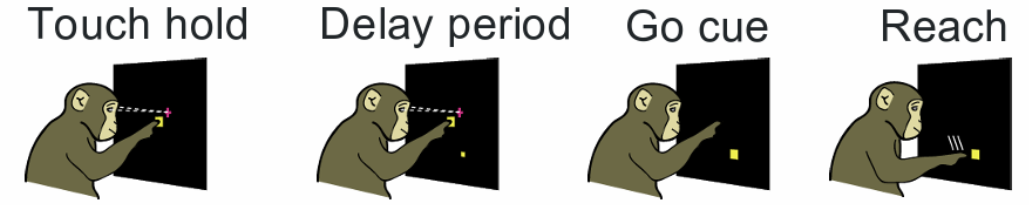

In [22]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).
                                                                      #Recomendamos mirar len(spike_times), len(spike_times[n]), etc. para entender bien los datos

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target


In [23]:
# Notar que hay dos duraciones de periodo de planificación
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005])

In [24]:
def extract_plan_spikes(window_length=None,
                        start_offset=None):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):#Para cada una de las neuronas (o más bien, para cada tren de disparo, que c/u pertenece a una neurona)
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el comienzo (trial_starts) o que el final del periodo de planificación (time_go_cue)")
                # plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append(#Sim
                np.array([np.sum((st > trial_starts[tx]) &
                        (st < trial_end)) for st in trialSpikes]))#Contamos cuantos disparos hubo en esa ventana!
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

In [25]:
#plan_spikes = extract_plan_spikes()
plan_spikes = extract_plan_spikes(window_length=750)

Separemos los episodios en set de entrenamiento y testeo

In [26]:
# selecciona los episodios con duración de periodo de planificación de 755 ms
short_trials = (time_go_cue - time_touch_held) == 755 # array booleano de longitud 1127 con todos los episodios de duración 755ms en 1 y el resto en 0

training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
test_trials = [] # todos los que sobran
for c in range(8): # targets del 0 al 7
    #target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()
    target_trials = np.argwhere((trial_reach_target==c)).squeeze()
    # seleccionar 25 episodios al azar (por cada dirección)
    random_training_trials = np.random.choice(target_trials, 25, replace=False)
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

    test_trials.extend(remaining_test_trials)


In [27]:
# Calcular el nro promedio de disparos por neurona y target
# Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
num_neurons = plan_spikes.shape[1]
mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)


In [28]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [29]:
# Calcula la probabilidad para cada target y cada episodio
poisson_likelihood = np.zeros((len(test_trials), 8))
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])


# 1.a
Para ver como varia la presicion, decidi ejecutar 10 veces ambos y tomar la media. Para el caso 1 (sin modificaciones) hay 364 episodios de testeo elegidos al azar y la media de porcentaje correcto de presicion fue de: 92.77%. Luego efectuando los cambios mencionados en la consigna, se pasa a tener 927 episodios de testeo con una media de porcentaje correcto de precisión de:  92.30%. Se puede observar que el agregar casi un 150% de casos de testeo, `no` llevó a un incremento en el porcentaje correcto de precisión.

In [30]:
correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
print('Porcentaje correcto: ', np.mean(correct_targets==decoded_targets)) #NOTA acá menciona el Ej1a!
print('({} episodios de testeo)'.format(len(test_trials)))

Porcentaje correcto:  0.9309600862998921
(927 episodios de testeo)


# 1.b
En la salida se esperaban 15 ítems, por lo cual decidí dividir el segmento de 0 a 750 en 15 secciones.
```py
window_lengths = np.arange(50,800,50)
```
Luego usamos estas window_lengths individualmente para extraer los spikes.
```py
plan_spikes = extract_plan_spikes(window_length=window_length) #seleccionar ventanas
```

In [31]:
decode_perf = []
window_lengths = np.arange(50,800,50)
for window_length in window_lengths: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=window_length) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

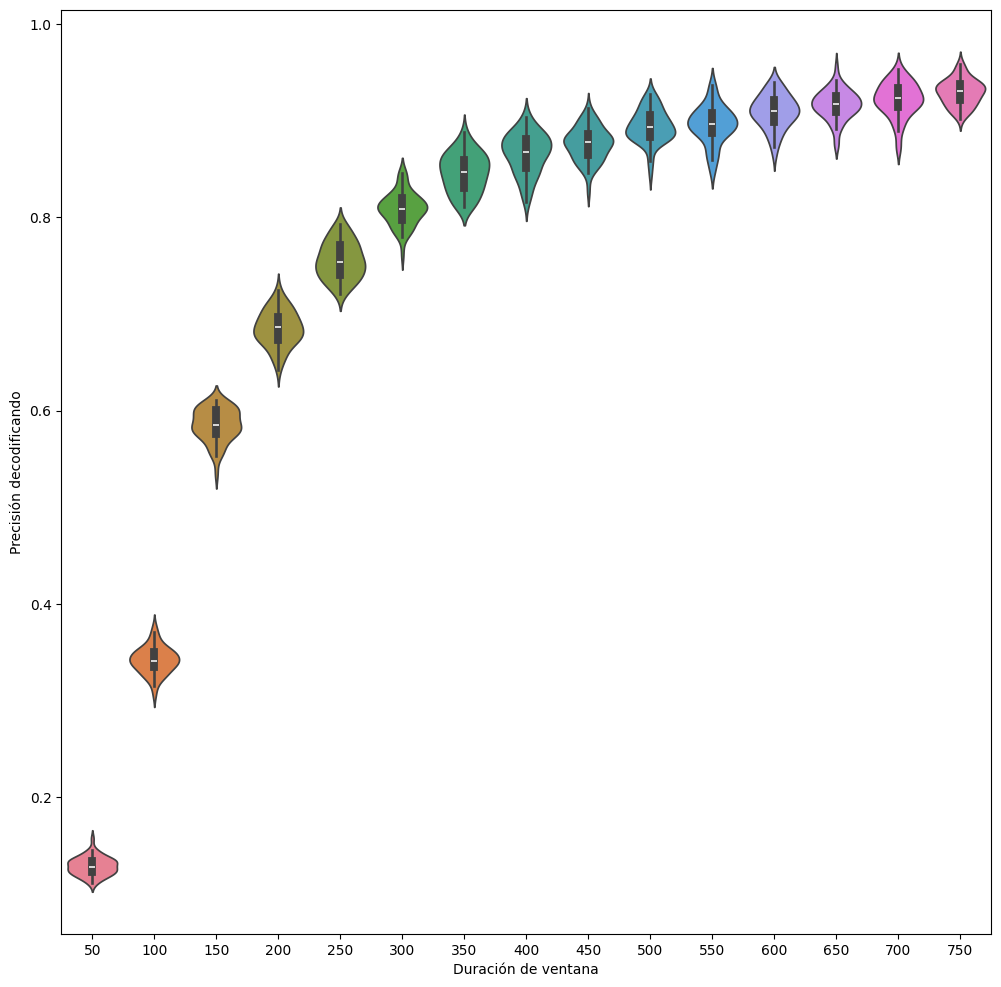

In [32]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=window_lengths))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Duración de ventana', ylabel='Precisión decodificando')
plt.show()


A medida que aumentamos la duración de la ventana, se incrementa la precisión de decodificado. Se puede apreciar que la mejora en precisión empieza a estancar a partir de una duración de ventana de 300/350.

# 1.c
Siguiendo la consigna apliqué una ventana de 250 ms. Dividi el segmento en 21 [0, 500] con saltos de 25.

In [33]:
decode_perf = []
offsets = np.arange(0,525,25)
for offset in offsets: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=offset) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

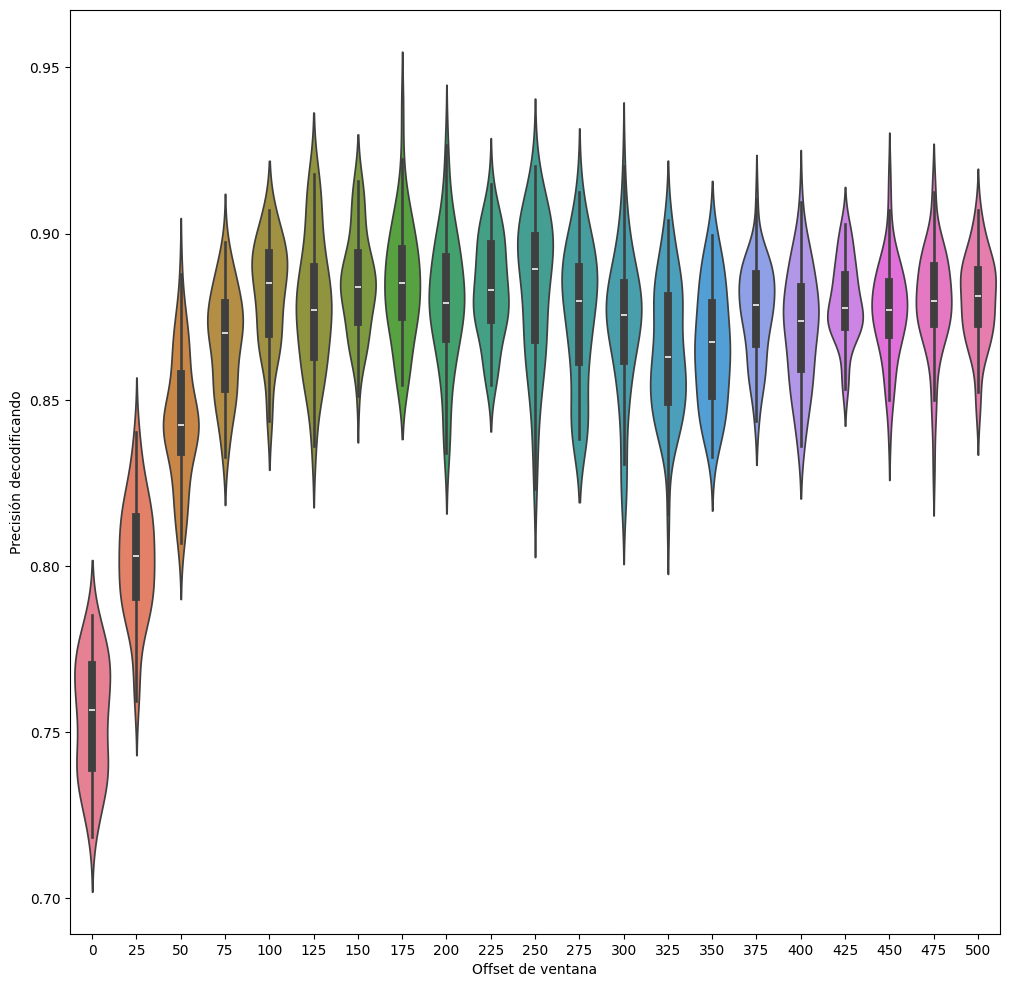

In [34]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=offsets))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Offset de ventana', ylabel='Precisión decodificando')
plt.show()

Analizando el gráfico podemos ver que de 0 a 100, vemos un incremento de precisión hasta llegar a una media al rededor de 87%. Luego, con los offsets que proceden, la precisión de decodificado oscila en valores similares. Por lo tanto, se podría decir que la actividad neuronal más útil aparece a partir de los 100 ms.

# 2.a
Fije la ventana en 250 ms con un offset inicial de 100 según lo indicado en la consigna. Cree la variable `grupos_neuronas` por la cual itero en el for principal para generar muestreados con grupos de 30, 60, 90, 120 y 150 neuronas. Para elegir los índices aleatoriamente agregué la siguiente línea que sobre el tamaño de la sample (`plan_spikes.shape [1]`), en la cual se elige `numero_neuronas` neuronas sin repetir índices.
```py
indices_neuronas = np.random.choice(plan_spikes.shape[1], nuemero_neuronas, replace=False)
```
Luego modifiqué un par de líneas más, para utilizar los índices de las neuronas seleccionadas en el muestreo.

In [35]:
decode_perf = []
grupos_neuronas = np.arange(30,180,30)
for numero_neuronas in grupos_neuronas: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        indices_neuronas = np.random.choice(plan_spikes.shape[1], numero_neuronas, replace=False)
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        # num_neurons = plan_spikes.shape[1]
        num_neurons = numero_neuronas
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:][:, indices_neuronas], axis=0)
            # mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            # poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
            poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials,:][:, indices_neuronas])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

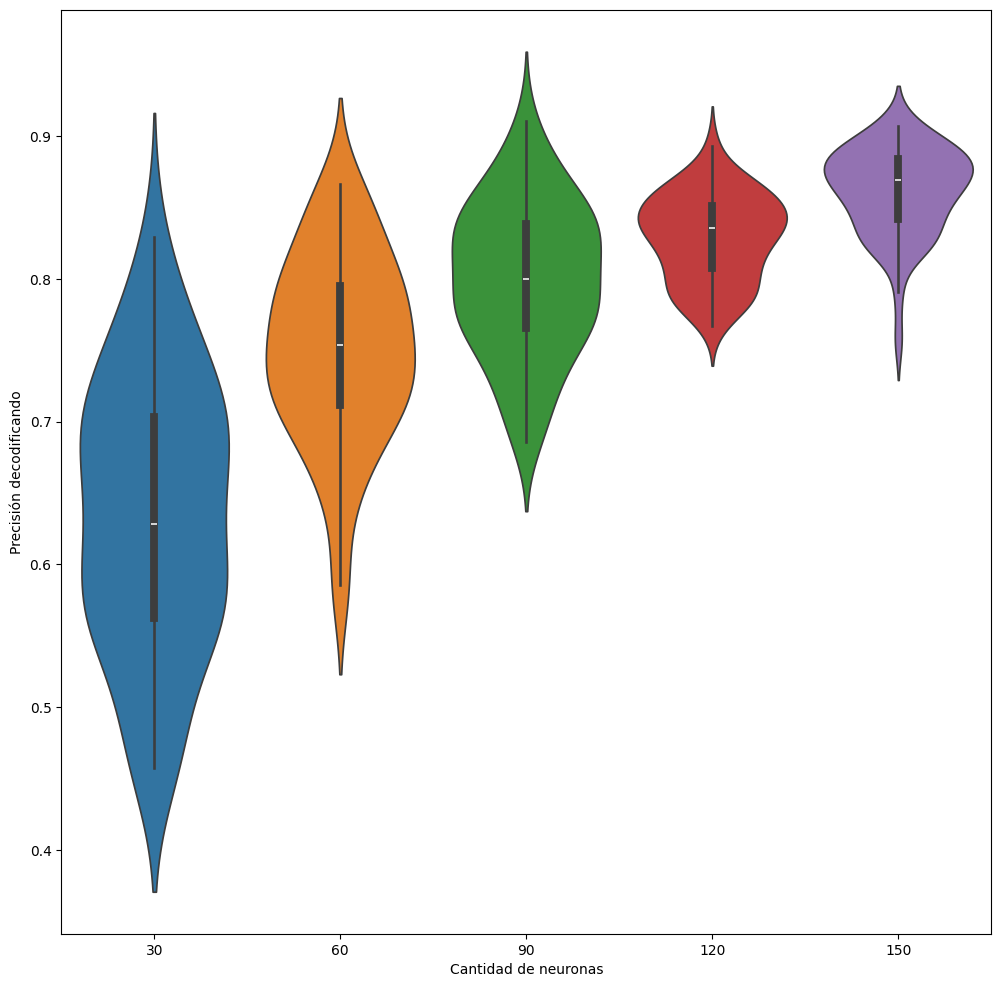

In [36]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=grupos_neuronas))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Cantidad de neuronas', ylabel='Precisión decodificando')
plt.show()

En este caso, continuamente a medida que incrementa la cantidad de neuronas, incrementa la precisión de decodificado. Si tomamos como límite de buen rendimiento 80%, los últimos tres tienen una media que sobrepasa.

# 2.b
Para realizar la selección de los índices definí el número de neuronas en 30 y cree 3 funciones lambda que reciben como parámetro el plan_spikes y se encargan de seleccionar las 30 más activas, las 30 menos activas y 30 aleatorias.

In [37]:
decode_perf = []
numero_neuronas = 30
indice_funciones = [
    lambda ps: np.argsort(np.mean(ps, axis= 0))[-numero_neuronas:],
    lambda ps: np.argsort(np.mean(ps, axis= 0))[:numero_neuronas],
    lambda ps: np.random.choice(ps.shape[1], numero_neuronas, replace=False)
]
for indice_funcion in indice_funciones: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        indices_neuronas = indice_funcion(plan_spikes)
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        # num_neurons = plan_spikes.shape[1]
        num_neurons = numero_neuronas
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:][:, indices_neuronas], axis=0)
            # mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            # poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
            poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials,:][:, indices_neuronas])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

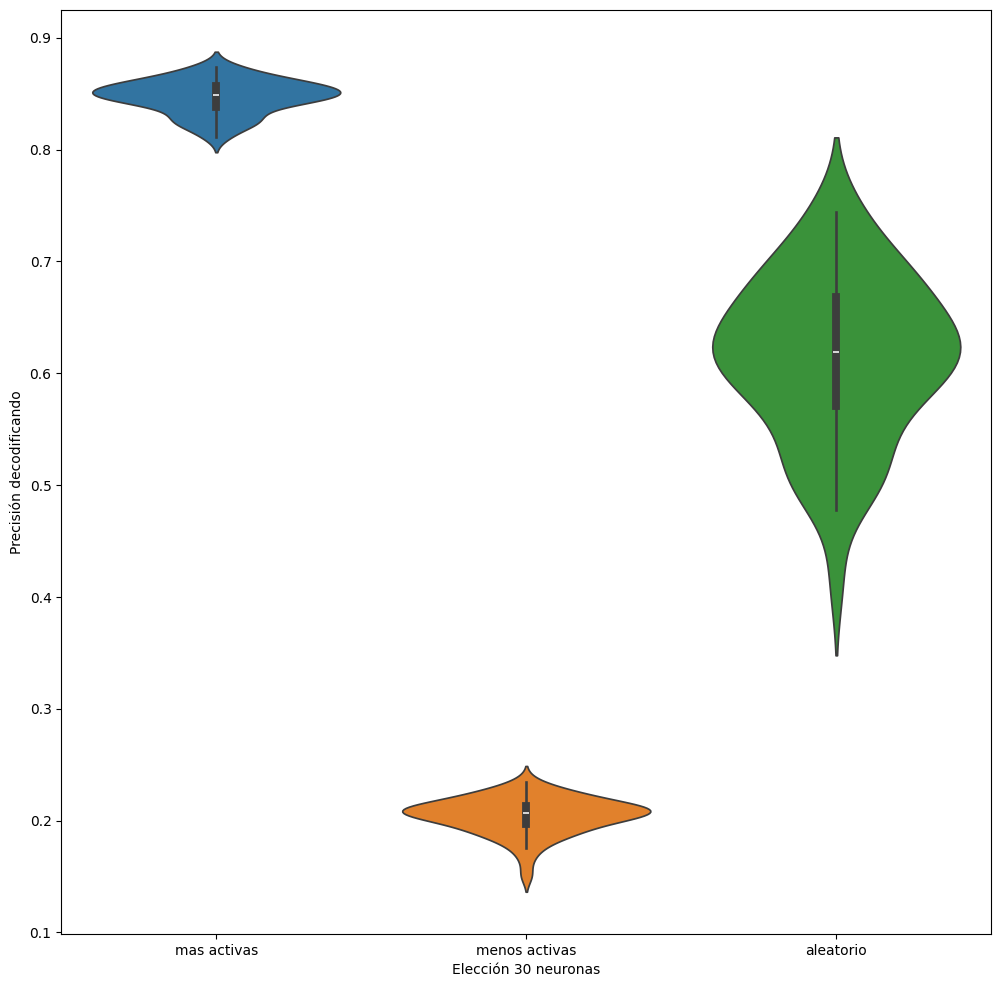

In [38]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
column_labels=['mas activas', 'menos activas', 'aleatorio']
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=column_labels))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Elección 30 neuronas', ylabel='Precisión decodificando')
plt.show()

Claramente, la selección de las 30 neuronas más activas favorece la precisión del decodificado con una precisión por encima del 85%. La peor selección es la de menos activas, con una precisión poco mayor al 20% y la selección aleatoria queda en el medio con precisión media superando levemente el 60%.

# 3.a
Al ejecutar el test tomando las muestras indicadas en la consigna, se obtiene lo siguiente:


In [39]:
decode_perf = []
tamanio_muestras = np.arange(5, 45, 5)
for tamanio_muestra in tamanio_muestras: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, tamanio_muestra, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

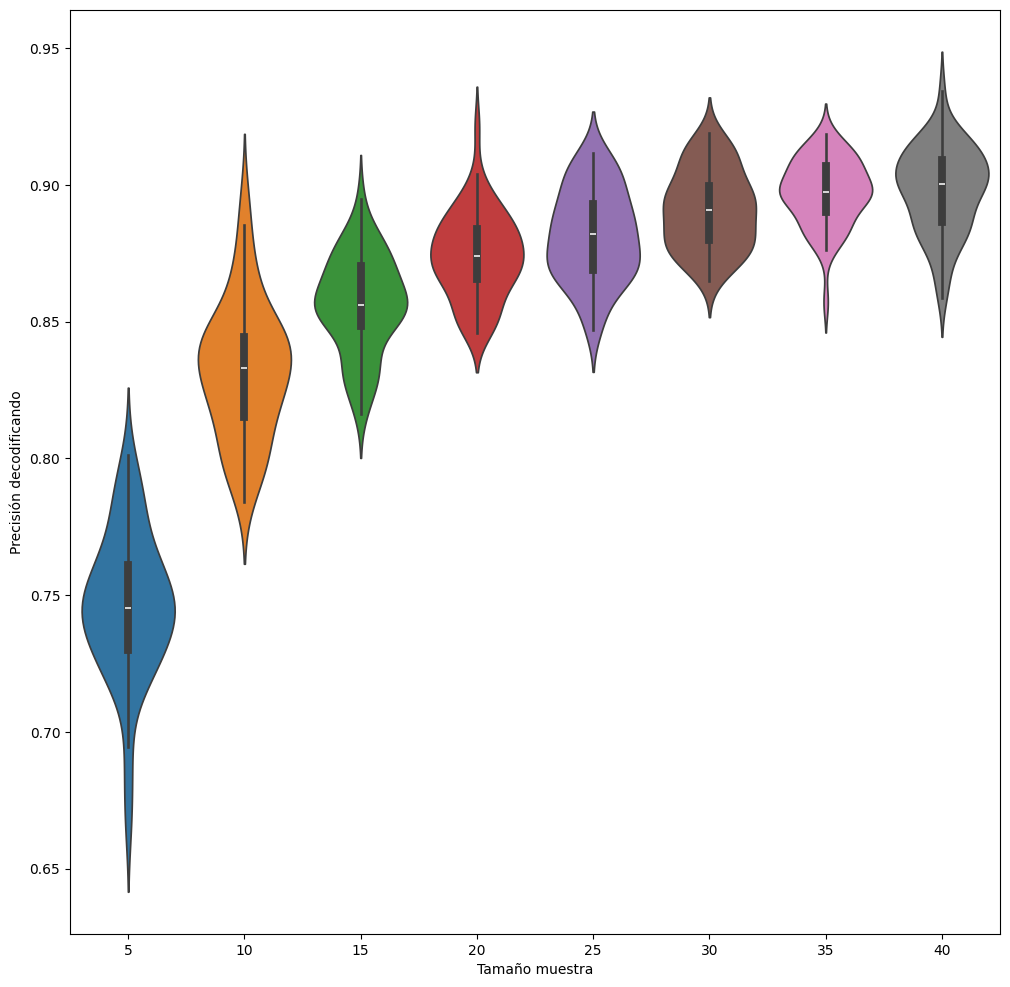

In [40]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=tamanio_muestras))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Tamaño muestra', ylabel='Precisión decodificando')
plt.show()

A medida que incrementamos el tamaño de la muestra, la precisión de decodificado incrementa. Si tomamos como límite 80% de precisión de decodificado, el único que no cumple es el tamaño de muestra de 5. Claramente, se ve beneficiada la precisión, que toma media de 90% al tomar 40 como tamaño de muestra.